### Semi-autonomous Teleoperation Demo : Place task in `Kitchen Plate` scene with `small size dish rack`

### Parse `Realistic Scene`

In [1]:
import mujoco,cv2,pyvista
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../../')
from utils.mujoco_parser import MuJoCoParserClass

from utils.util import sample_xyzs,rpy2r,r2rpy,r2quat,compute_view_params,get_interp_const_vel_traj, printmd
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

/home/rilab/.pyenv/versions/3.8.8/envs/mujoco/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-19 13:02:30,337	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


MuJoCo version:[2.3.5]


In [2]:
# xml_path = '../../../asset/scene_kitchen_dish_rack_white.xml'
xml_path = '../../../asset/visualize_figure_dish_rack_white.xml'

env = MuJoCoParserClass(name='Place task scene: Plate table',rel_xml_path=xml_path,VERBOSE=False, MODE='window')
print(env.MODE)

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('ur_base').pos = np.array([0.18,0,0.79])
env.model.body('avoiding_object_table').pos = np.array([0.38+0.45,0,0])
env.model.body('right_object_table').pos = np.array([-0.05,-0.80,0])
env.model.body('left_object_table').pos = np.array([-1.5,80,0])

# Place objects
obj_box_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_box"))]
n_box_obj = len(obj_box_names)
env.place_objects_random(n_obj=n_box_obj, obj_names=obj_box_names, x_range=[0.80, 1.15], y_range=[-3.15, -2.15], COLORS=False, VERBOSE=True)

jntadr_mug_cup = env.model.body('mug_cup').jntadr[0]
env.model.joint(jntadr_mug_cup).qpos0[:3] = np.array([ -0.9, -30, 0.85])
env.model.joint(jntadr_mug_cup).qpos0[3:] = r2quat(rpy2r(np.radians([0, 0, np.random.rand() * 360])))

jntadr_tray = env.model.body('tray').jntadr[0]
env.model.joint(jntadr_tray).qpos0[:3] = np.array([-0.9,-30,0.80])
# env.model.joint(jntadr_tray).qpos0[3:] = r2quat(rpy2r(np.radians([0, 0, 0])))

jntadr_dish_rack = env.model.body('dish_rack').jntadr[0]
pos_dish_rack = np.array([0.9,0.0,0.82])
env.model.joint(jntadr_dish_rack).qpos0[:3] = pos_dish_rack
dish_rack_random_rot = 90 # np.random.rand() * 360
env.model.joint(jntadr_dish_rack).qpos0[3:] = r2quat(rpy2r(np.radians([0, 0, dish_rack_random_rot])))


# Target dish
env.model.joint(env.model.body('kitchen-plate').jntadr[0]).qpos0[:3] = np.array([0.2, -0.7, 0.8])
# Set the dishes
env.model.joint(env.model.body('kitchen-plate-2').jntadr[0]).qpos0[:3] = np.array([-0.92, 0.39, 0.95])
env.model.joint(env.model.body('kitchen-plate-2').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([0, 90, 90])))
env.model.joint(env.model.body('kitchen-plate-3').jntadr[0]).qpos0[:3] = np.array([[0.90, -0.06, 0.95]])
env.model.joint(env.model.body('kitchen-plate-3').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([0, 90, 90])))
env.model.joint(env.model.body('kitchen-plate-4').jntadr[0]).qpos0[:3] = np.array([[0.90, -0.04, 0.95]])
env.model.joint(env.model.body('kitchen-plate-4').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([0, 90, 90])))
# env.model.joint(env.model.body('kitchen-plate-2').jntadr[0]).qpos0[:3] = pos_dish_rack + np.array([0.0,0.02, 0.2])
# env.model.joint(env.model.body('kitchen-plate-3').jntadr[0]).qpos0[:3] = pos_dish_rack + np.array([-0.05, 0.02, 0.2])
# env.model.joint(env.model.body('kitchen-plate-4').jntadr[0]).qpos0[:3] = pos_dish_rack + np.array([-0.1, 0.02, 0.2])

env.reset()

window


In [3]:
pcds = np.load('../data_score/feasible_white_rack.npy')
# pcds = np.load('../data_score/workspace_white_rack_dense.npy')

[ 0.5  -0.01  1.16]
Pressed ESC
Quitting.


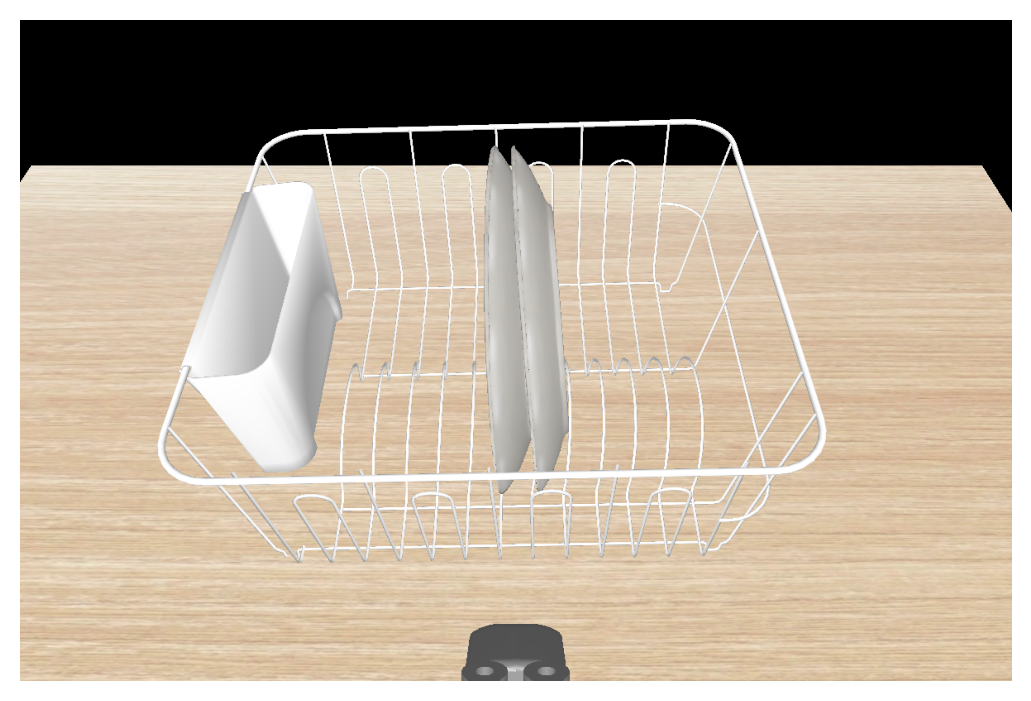

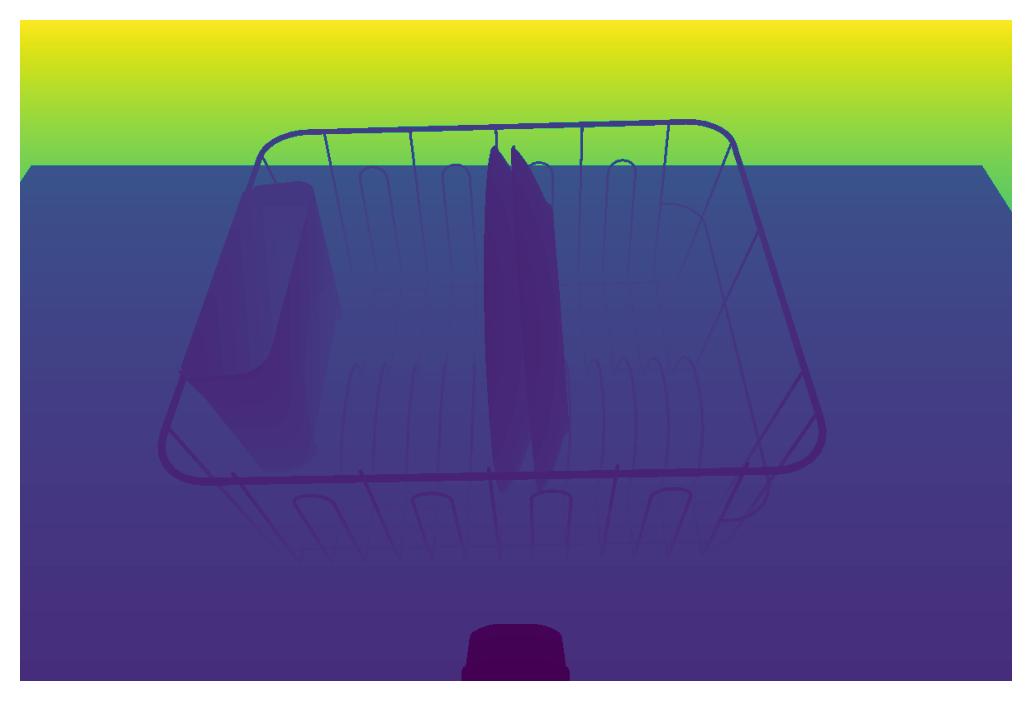

Done. Tick:[927] Time:[1.85]sec


In [24]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=150,distance=3.0,elevation=-30,lookat=[0.4,0.0,0.81],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

pcd_tick = 0

# Reset
env.reset()
# init_ur_q = np.array([0,0,0,0,np.deg2rad(90),0])
init_ur_q = np.array([np.deg2rad(-90), np.deg2rad(-130), np.deg2rad(120), np.deg2rad(100), np.deg2rad(45), np.deg2rad(-90)])
env.forward(q=init_ur_q, joint_idxs=env.idxs_forward)
initial_xyz = env.get_p_body('ur_tcp_link')
print(env.get_p_body('ur_tcp_link'))
tick,max_sec = 0,1000
while env.get_sim_time() <= max_sec:
    env.step(ctrl=init_ur_q,ctrl_idxs=env.idxs_step)
    if not env.is_viewer_alive(): break

    # Render
    if env.loop_every(HZ=20):
        # Compute some poses
        p_tcp,R_tcp = env.get_pR_body(body_name='ur_tcp_link')
        p_cam,R_cam = env.get_pR_body(body_name='ur_camera_center')
        p_base,R_base = env.get_pR_body(body_name='ur_base')
        # Get PCD from a specific view
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2] + np.array([0,0,-0.1])
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=40,fovy=45,BACKUP_AND_RESTORE_VIEW=True)
        # [env.plot_sphere(p=sampled_place_, r=0.005, rgba=[0,1.,0,1]) for sampled_place_ in pcds]
        env.render(render_every=1)

plt.imshow(rgb_img); plt.axis('off'); plt.show()
plt.imshow(depth_img); plt.axis('off'); plt.show()

# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

In [15]:
env.init_viewer(viewer_title='IK solver',viewer_width=1200,viewer_height=800,viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=80,distance=2.5,elevation=-30,lookat=[0,0,1.5])
env.update_viewer(VIS_JOINT=False,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset() # reset

p_target = np.array([0.8, 0.3, 0.9])
R_target = rpy2r(np.array([-90,0,90])*np.pi/180.0)
q_init = np.array([np.deg2rad(-90), np.deg2rad(-130), np.deg2rad(120), np.deg2rad(100), np.deg2rad(45), np.deg2rad(-90)])
q_init_upright = np.array([0,-np.pi/2,0,0,np.pi/2,0])
q_ik_target = env.solve_ik_repel(
    body_name='ur_tcp_link',p_trgt=p_target,R_trgt=R_target,
    IK_P=True,IK_R=True, q_init=q_init,idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
    inc_prefix = 'ur', exc_prefix=None,
    RESET=False, DO_RENDER=True, th=1, err_th=1e-3, stepsize=1, w_weight=0.3, render_every=1.0, repulse=10, VERBOSE=True)

print(f"Initial Joint values: {q_init}")
print(f"Solved IK: {q_ik_target}")

# Close viewer
env.close_viewer()
print ("Done.")

['ur_upper_arm_link'] ['ur_rg2_gripper_base_link']
Collision with ur_upper_arm_link and ['ur_rg2_gripper_base_link']
Initial Joint values: [-1.57 -2.27  2.09  1.75  0.79 -1.57]
Solved IK: [ 0.25 -0.44  0.35  1.66  1.57  0.25]
Done.


[0.28 0.13 2.04]
Pressed ESC
Quitting.


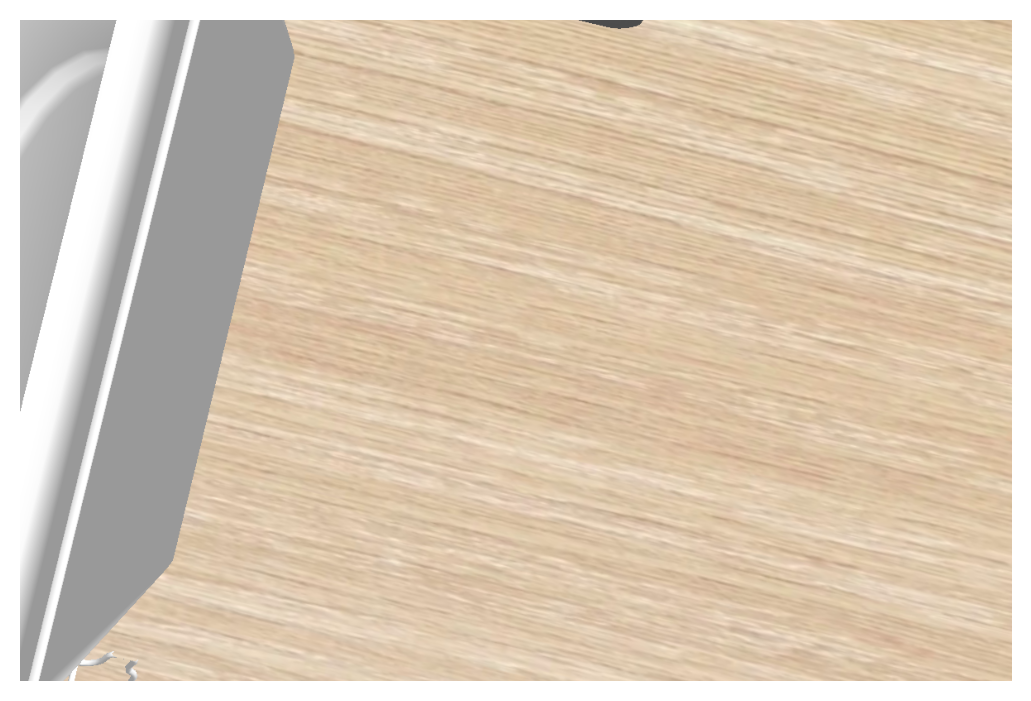

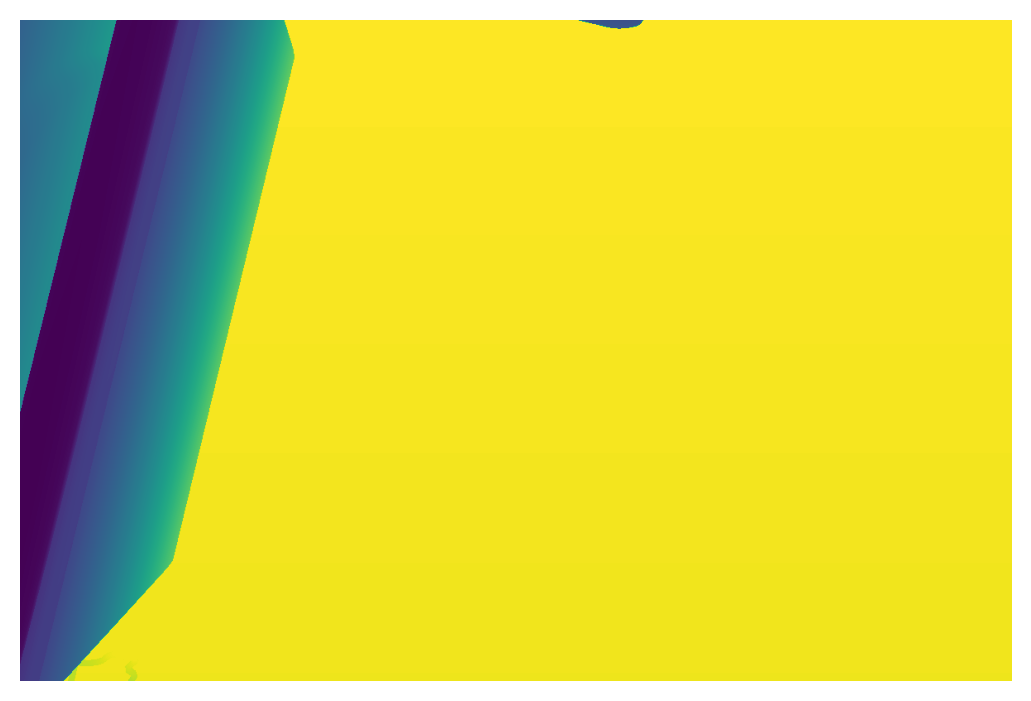

Done. Tick:[1477] Time:[2.95]sec


In [16]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=150,distance=3.0,elevation=-30,lookat=[0.4,0.0,0.81],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

pcd_tick = 0

# Reset
env.reset()
# init_ur_q = np.array([0,0,0,0,np.deg2rad(90),0])
init_ur_q = np.array([np.deg2rad(-90), np.deg2rad(-130), np.deg2rad(120), np.deg2rad(100), np.deg2rad(45), np.deg2rad(-90)])
env.forward(q=q_init_upright, joint_idxs=env.idxs_forward)
initial_xyz = env.get_p_body('ur_tcp_link')
print(env.get_p_body('ur_tcp_link'))
tick,max_sec = 0,1000
while env.get_sim_time() <= max_sec:
    env.step(ctrl=q_ik_target,ctrl_idxs=env.idxs_step)
    if not env.is_viewer_alive(): break

    # Render
    if env.loop_every(HZ=300):
        # Compute some poses
        p_tcp,R_tcp = env.get_pR_body(body_name='ur_tcp_link')
        p_cam,R_cam = env.get_pR_body(body_name='ur_camera_center')
        p_base,R_base = env.get_pR_body(body_name='ur_base')
        # Get PCD from a specific view
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2] + np.array([0,0,-0.1])
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=40,fovy=45,BACKUP_AND_RESTORE_VIEW=True)
        # [env.plot_sphere(p=sampled_place_, r=0.005, rgba=[0,1.,0,1]) for sampled_place_ in pcds]
        env.render(render_every=1)

plt.imshow(rgb_img); plt.axis('off'); plt.show()
plt.imshow(depth_img); plt.axis('off'); plt.show()

# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

In [39]:
def solve_ik_for_target_name(env:MuJoCoParserClass, target_name, target_p, q_init, MODE='window'):
    env.init_viewer(viewer_title='UR5e with RG2 gripper and objects', viewer_width=1200, viewer_height=800,
                    MODE=MODE, viewer_hide_menus=True)
    env.update_viewer(azimuth=124.08, distance=4.00, elevation=-33, lookat=[0.1, 0.05, 0.86],
                    VIS_TRANSPARENT=False, VIS_CONTACTPOINT=True,
                    contactwidth=0.05, contactheight=0.05, contactrgba=np.array([1, 0, 0, 1]),
                    VIS_JOINT=False, jointlength=0.2, jointwidth=0.05, jointrgba=[0.2, 0.6, 0.8, 1.0])
    env.reset()  # reset
    env.forward(q=q_init, joint_idxs=env.idxs_forward)

    stepsize = 1.0
    render_every = 1
    th = 5*np.pi/180.0
    err_th = 1e-2
    repulse = 0
    eps = 0.5
    
    # Configuration
    DO_RENDER = True

    # 1. Turn UR Base
    body_name = 'ur_tcp_link'
    p_base = env.get_p_body(body_name='ur_base')
    p_trgt = env.get_p_body(target_name)
    p_trgt[1] = p_trgt[1] + 0.1
    p_trgt[2] = p_trgt[2] + 0.3
    R_trgt = rpy2r(np.radians([-180, 0, 0]))
    q_turn_base = env.solve_ik_repel(eps = eps, repulse = repulse,
        body_name=body_name, p_trgt=p_trgt, R_trgt=R_trgt, IK_P=True, IK_R=True,
        q_init=q_init, idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
        inc_prefix = 'ur', exc_prefix=None,
        RESET=False, DO_RENDER=DO_RENDER, th=th, err_th=err_th, stepsize=stepsize, render_every=render_every)

    # 1. Solve IK for the pre-grasping position
    p_base = env.get_p_body(body_name='ur_base')
    p_trgt = env.get_p_body(target_name)
    p_trgt[1] = p_trgt[1] + 0.1
    p_trgt[2] = p_base[2] + 0.05
    R_trgt = rpy2r(np.radians([-180, 0, 0]))
    q_pre_grasp = env.solve_ik_repel(eps = eps, repulse = repulse,
        body_name=body_name, p_trgt=p_trgt, R_trgt=R_trgt, IK_P=True, IK_R=True,
        q_init=q_turn_base, idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
        inc_prefix = 'ur', exc_prefix=None,
        RESET=False, DO_RENDER=DO_RENDER, th=th, err_th=err_th, stepsize=stepsize, render_every=render_every)

    p_trgt = env.get_p_body(target_name)
    p_trgt[2] = p_base[2] + 0.05
    R_trgt = rpy2r(np.radians([-180, 0, 0]))
    q_grasp = env.solve_ik_repel(eps = eps, repulse = repulse,
        body_name=body_name, p_trgt=p_trgt, R_trgt=R_trgt, IK_P=True, IK_R=True,
        q_init=q_pre_grasp, idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
        inc_prefix = 'ur', exc_prefix=None,
        RESET=False, DO_RENDER=DO_RENDER, th=th, err_th=err_th, stepsize=stepsize, render_every=render_every)

    # 2. Solve IK for the lift-up position
    p_trgt = env.get_p_body(target_name)
    p_trgt[2] = p_base[2] + 0.05 + 0.3
    R_trgt = rpy2r(np.radians([-135, 0, 0]))
    q_liftup = env.solve_ik_repel(eps = eps, repulse = repulse,
        body_name=body_name, p_trgt=p_trgt, R_trgt=R_trgt, IK_P=True, IK_R=True,
        q_init=q_grasp, idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
        inc_prefix = 'ur', exc_prefix=None,
        RESET=False, DO_RENDER=DO_RENDER, th=th, err_th=err_th, stepsize=stepsize, render_every=render_every)

    # 3. Waypoint 1
    p_trgt = np.array([0.65, 0.  , 1.25])   # 0.14, 0, 1.14
    p_trgt[2] = p_base[2] + 0.05 + 0.3
    R_trgt = rpy2r(np.radians([-90, 0, 90]))
    q_waypoint1 = env.solve_ik_repel(eps = eps, repulse = repulse,
        body_name=body_name, p_trgt=p_trgt, R_trgt=R_trgt, IK_P=True, IK_R=True,
        q_init=q_liftup, idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
        inc_prefix = 'ur', exc_prefix=None,
        RESET=False, DO_RENDER=DO_RENDER, th=th, err_th=err_th, stepsize=stepsize, render_every=render_every)

    # 4. Solve IK for the place position
    p_trgt = target_p.copy()
    # p_trgt[1] = p_base[0] + 0.7
    # p_trgt[2] = p_base[2] + 0.1 + 0.1
    R_trgt = rpy2r(np.radians([-90, 0, 90]))
    q_place = env.solve_ik_repel(eps = eps, repulse = repulse,
        body_name=body_name, p_trgt=p_trgt, R_trgt=R_trgt, IK_P=True, IK_R=True,
        q_init=q_waypoint1, idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
        inc_prefix = 'ur', exc_prefix=None,
        RESET=False, DO_RENDER=DO_RENDER, th=th, err_th=err_th, stepsize=stepsize, render_every=render_every)

    # 5. Reset to init pose
    p_trgt = np.array([0.65, 0.  , 1.25])   # 0.14, 0, 1.14
    R_trgt = rpy2r(np.radians([-180, 0, 90]))
    q_reset = env.solve_ik_repel(eps = eps, repulse = repulse,
        body_name=body_name, p_trgt=p_trgt, R_trgt=R_trgt, IK_P=True, IK_R=True,
        q_init=q_place, idxs_forward=env.idxs_forward, idxs_jacobian=env.idxs_jacobian,
        inc_prefix = 'ur', exc_prefix=None,
        RESET=False, DO_RENDER=DO_RENDER, th=th, err_th=err_th, stepsize=stepsize, render_every=render_every)


    # Close viewer
    env.close_viewer()
    print("IK done.")
    print("q_grasp:%s" % (np.degrees(q_grasp)))
    print("q_liftup:%s" % (np.degrees(q_liftup)))
    print("q_waypoint1:%s" % (np.degrees(q_waypoint1)))
    print("q_place:%s" % (np.degrees(q_place)))
    
    return [q_turn_base, q_pre_grasp, q_grasp, q_liftup, q_waypoint1, q_place, q_reset]

# Origin
capture_q = np.array([np.deg2rad(-90), np.deg2rad(-132.46), np.deg2rad(122.85), np.deg2rad(99.65), np.deg2rad(45), np.deg2rad(-90.02)])
# Modified
# capture_q = np.array([np.deg2rad(-180), np.deg2rad(-30), np.deg2rad(-120), np.deg2rad(125), np.deg2rad(-90), np.deg2rad(0)])

q_init = np.radians([0, -90, 0, 0, 0, 0])
q_init = q_init
q_list = []

p_target = np.array([0.6, 0.3, 0.85])
object_sequence = [0]
obj_names = ["kitchen-plate"]
obj_num = len(object_sequence)
for object_sequence_ in object_sequence:
    target_name = obj_names[object_sequence_]
    q_res = solve_ik_for_target_name(env, target_name, p_target, q_init)
    q_init = q_res[-1]
    q_list.append(q_res)

# target_name = obj_names[0]
# q_res = solve_ik_for_target_name(env, target_name, p_target, q_init)
# q_init = q_res[-1]
# q_list.append(q_res)


q_array = np.array(q_list)
print("planned joint trajectory:",q_array)

IK done.
q_grasp:[-106.39  -54.37  121.23  -66.98   73.5     0.03]
q_liftup:[-103.27  -66.95   59.52   53.03   80.62   -9.44]
q_waypoint1:[-16.97 -68.68  60.51  98.07  89.95 -16.98]
q_place:[ 20.19 -53.49  79.44  64.2   89.95  20.13]
planned joint trajectory: [[[-1.9  -1.67  2.13 -0.45  1.24 -0.  ]
  [-1.92 -1.08  2.38 -1.3   1.22 -0.  ]
  [-1.86 -0.95  2.12 -1.17  1.28  0.  ]
  [-1.8  -1.17  1.04  0.93  1.41 -0.16]
  [-0.3  -1.2   1.06  1.71  1.57 -0.3 ]
  [ 0.35 -0.93  1.39  1.12  1.57  0.35]
  [-0.67 -2.15  2.04  0.11  0.9   0.  ]]]


In [35]:
import matplotlib.pyplot as plt
from utils.util import get_interp_const_vel_traj

q_traj_list = []
times_list = []
q_array_flatten = np.concatenate([capture_q.reshape(1,6) ,q_array.reshape(-1,6)])
for q_before, q_after in zip(q_array_flatten[:-1], q_array_flatten[1:]):
    q_array_ = np.vstack([q_before, q_after])
    times, q_traj = get_interp_const_vel_traj(q_array_, vel=np.radians(30), HZ=env.HZ)
    print("Joint trajectory ready. duration:[%.2f]sec" % (times[-1]))
    
    q_traj_list.append(q_traj)
    times_list.append(times)

Joint trajectory ready. duration:[4.18]sec
Joint trajectory ready. duration:[1.62]sec
Joint trajectory ready. duration:[0.51]sec
Joint trajectory ready. duration:[4.00]sec
Joint trajectory ready. duration:[2.88]sec
Joint trajectory ready. duration:[1.24]sec
Joint trajectory ready. duration:[2.32]sec


In [38]:
# Gripper openning should be done by calling step()
env.init_viewer(viewer_title='UR5e with RG2 gripper and objects',viewer_width=1200,viewer_height=800,
                MODE='window', viewer_hide_menus=True)
env.update_viewer(azimuth=124.08,distance=4.00,elevation=-33,lookat=[0.1,0.05,0.86],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.2,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,1.0])

# Reset and initialize the joint position
env.reset() # reset

env.forward(q=capture_q,joint_idxs=env.idxs_forward)
env.update_viewer(azimuth=170,distance=2.5,lookat=env.get_p_body(body_name='ur_tcp_link'))

        
# q_array_flatten = q_array.reshape(-1,6)

OPEN = True
CLOSE = False

grasp_list = [OPEN, OPEN, OPEN, CLOSE, CLOSE, CLOSE, OPEN]
grasp_len = len(grasp_list)

for i,q_traj_ in enumerate(q_traj_list):
    for q_ in q_traj_:
        start_time = env.get_sim_time()
        
        # while ((env.get_sim_time()-start_time) < time_margin[i%4]):
        
        env.step(ctrl=q_,ctrl_idxs=env.idxs_step)
        env.step(ctrl=float(grasp_list[i%grasp_len]),ctrl_idxs=6)

        p_tcp,R_tcp = env.get_pR_body(body_name='ur_tcp_link')
        p_base,R_base = env.get_pR_body(body_name='ur_base')
        env.plot_T(p=p_tcp,R=R_tcp,PLOT_AXIS=True,axis_len=0.1,axis_width=0.005)
        env.plot_T(p=p_base,R=R_base,PLOT_AXIS=True,axis_len=1.0,axis_width=0.005)
        env.render(render_every=10)

print ("Done.")

# Close viewer
env.close_viewer()

Done.
